In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

def combined_analysis_and_visualization(result_path, param_name, standard_pxrd_params=None, prefix="", folder="figures", show_exp_params=False, metrics_log=False):
    
    # Load data
    with open(result_path, "rb") as f:
        data = pickle.load(f)
    results = data["results"]
    default_params_dict = data["config"]["default_params_dict"]
    
    # Ensure the output folder exists.
    os.makedirs(folder, exist_ok=True)

    aggregated = {}
    for combo_key, exp_list in results.items():
        for exp in exp_list:
            if param_name not in exp["params"]:
                continue  # Skip if param_name is missing (when combinatory=False)
            
            param_val = exp["params"][param_name]
            if str(param_val) not in aggregated:
                aggregated[str(param_val)] = {"valid": [], "rwp": []}
            # Validity as percentage: 100 if valid, 0 otherwise.
            aggregated[str(param_val)]["valid"].append(100 * (1 if exp["val"] else 0))
            aggregated[str(param_val)]["rwp"].append(exp["rwp"])
    
    if not aggregated:
        print(f"No valid data found for parameter: {param_name}")
        return

    # Sort the parameter values and calculate statistics.
    sorted_param_vals = sorted(aggregated.keys())
    validity_means, validity_stds, rwp_means, rwp_stds = [], [], [], []
    for val in sorted_param_vals:
        valid_vals = np.array(aggregated[val]["valid"])
        rwp_vals = np.array(aggregated[val]["rwp"])
        validity_means.append(np.mean(valid_vals))
        validity_stds.append(np.std(valid_vals))
        rwp_means.append(np.mean(rwp_vals))
        rwp_stds.append(np.std(rwp_vals))
    
    sorted_param_vals = np.array(sorted_param_vals)
    validity_means = np.array(validity_means)
    validity_stds = np.array(validity_stds)
    rwp_means = np.array(rwp_means)
    rwp_stds = np.array(rwp_stds)
    
    if standard_pxrd_params is None:
        standard_pxrd_params = {
            "qmin": 0.0,
            "qmax": 10.0,
            "qstep": 0.01,
            "base_fwhm": 0.05,
            "eta": 0.5
        }
    for key, val in standard_pxrd_params.items():
        if key in default_params_dict:
            standard_pxrd_params[key] = default_params_dict[key]
            
    # Select the best result (lowest rwp) for each unique parameter value.
    best_results = {}
    for combo_key, exp_list in results.items():
        if param_name not in exp_list[0]["params"]:
            continue
        
        param_val = exp_list[0]['params'][param_name]
        best_result = min(exp_list, key=lambda x: x['rwp'])
        best_results[str(param_val)] = best_result

    # Create the dual y-axis aggregated plot.
    fig, ax1 = plt.subplots(figsize=(6, 6))
    ax2 = ax1.twinx()
    ax1.plot(sorted_param_vals, validity_means, 'o-', color='blue', label="Validity (%)")
    ax1.fill_between(sorted_param_vals, validity_means - validity_stds, validity_means + validity_stds,
                     color='blue', alpha=0.3)
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Validity (%)", color="blue")
    if metrics_log:
        ax1.set_xscale("log")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    ax2.plot(sorted_param_vals, rwp_means, 'o-', color='green', label="RWP")
    
    best_rwp = [best_results[val]['rwp'] for val in sorted_param_vals]
    ax2.plot(sorted_param_vals, best_rwp, 'o-', color='purple', label="Best RWP")
    
    ax2.fill_between(sorted_param_vals, rwp_means - rwp_stds, rwp_means + rwp_stds,
                     color='green', alpha=0.3)
    ax2.set_ylabel("RWP", color="green")
    if metrics_log:
        ax2.set_xscale("log")
    ax2.tick_params(axis='y', labelcolor="green")

    # Combine legends from both axes.
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    
    
    
    plt.title(f"Validity and RWP vs. {param_name} (Aggregated)")
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(folder, f"{prefix}_validity_rwp.png"))

    sorted_param_vals = sorted(best_results.keys())
    
    for val in sorted_param_vals:
        res = best_results[val]
        
        # Retrieve the reference and generated structures.
        ref_struct = res["reference_structure"]
        gen_struct = res["generated_structure"]
        
        # Retrieve the PXRD results computed with experiment parameters.
        pxrd_exp_ref = res["pxrd_ref"]
        pxrd_exp_gen = res["pxrd_gen"]
        
        # Compute the standard PXRD for both reference and generated structures.
        pxrd_std_ref = pxrd_from_cif(res["reference_cif"], debug=True, **standard_pxrd_params)
        pxrd_std_gen = pxrd_from_cif(res["generated_cif"], debug=True, **standard_pxrd_params)
        
        # Create a figure using GridSpec:
        fig = plt.figure(figsize=(8, 10))
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
        ax_pxrd = fig.add_subplot(gs[0, :])
        ax_ref = fig.add_subplot(gs[1, 0])
        ax_gen = fig.add_subplot(gs[1, 1])
        
        # Top row: PXRD comparison spanning full width.
        ax_pxrd.plot(pxrd_exp_ref["q"], pxrd_exp_ref["iq"], label="Ref PXRD (Exp Params)", color="black", lw=2)
        if show_exp_params:
            ax_pxrd.plot(pxrd_exp_gen["q"], pxrd_exp_gen["iq"], label="Gen PXRD (Exp Params)", color="red", lw=2)
        ax_pxrd.plot(pxrd_std_ref["q"], pxrd_std_ref["iq"], '--', label="Ref PXRD (Standard)", color="gray", lw=2)
        ax_pxrd.plot(pxrd_std_gen["q"], pxrd_std_gen["iq"], label="Gen PXRD (Standard)", color="orange", lw=2)
        ax_pxrd.set_xlabel("Q")
        ax_pxrd.set_ylabel("Intensity")
        ax_pxrd.set_title(f"PXRD Comparison (Param: {param_name} = {val})")
        ax_pxrd.legend(loc="best")
        
        atoms_ref = AseAtomsAdaptor.get_atoms(ref_struct)
        plot_atoms(atoms_ref, ax=ax_ref, show_unit_cell=1, radii=0.5, rotation=('45x,45y,0z'))
        ax_ref.set_title(f"Reference Unit Cell")
        ax_ref.axis("off")
        ax_ref.set_aspect('equal')  # Ensure equal aspect ratio
        ax_ref.autoscale()          # Auto-adjust view limits
        # ax_ref.set_xlim([0, 8.5])
        # ax_ref.set_ylim([-2,6.5])
        
        # Add legend text with composition and space group.
        ref_formula = ref_struct.composition.reduced_formula
        ref_sg = ref_struct.get_space_group_info()[0]
        ax_ref.text(0.02, 0.98, f"Formula: {ref_formula}\nSpacegroup: {ref_sg}",
                    transform=ax_ref.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        atoms_gen = AseAtomsAdaptor.get_atoms(gen_struct)
        plot_atoms(atoms_gen, ax=ax_gen, show_unit_cell=1, radii=0.5, rotation=('45x,45y,0z'))
        ax_gen.set_title(f"Generated Unit Cell")
        ax_gen.axis("off")
        ax_gen.set_aspect('equal')  # Ensure equal aspect ratio
        ax_gen.autoscale()          # Auto-adjust view limits
        # ax_gen.set_xlim([0, 8.5])
        # ax_gen.set_ylim([-2,6.5])
        
        # Add legend text with composition and space group.
        gen_formula = gen_struct.composition.reduced_formula
        gen_sg = gen_struct.get_space_group_info()[0]
        ax_gen.text(0.02, 0.98, f"Formula: {gen_formula}\nSpacegroup: {gen_sg}",
                    transform=ax_gen.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        # Adjust layout and save the figure.
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        fig.savefig(os.path.join(folder, f"{prefix}_{param_name}_{val}.png"))


In [41]:
# Load data
with open("../ablation_results_comp.pkl", "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]
params_dict = data["config"]["params_dict"]

In [44]:
param_name = 'particle_size'

aggregated = {}
for combo_key, exp_list in results.items():
    for exp in exp_list:
        if param_name not in exp["params"]:
            continue  # Skip if param_name is missing (when combinatory=False)
        
        param_val = exp["params"][param_name]
        if str(param_val) not in aggregated:
            aggregated[str(param_val)] = {"valid": [], "rwp": []}
        # Validity as percentage: 100 if valid, 0 otherwise.
        aggregated[str(param_val)]["valid"].append(100 * (1 if exp["val"] else 0))
        aggregated[str(param_val)]["rwp"].append(exp["rwp"])
    
# Sort the parameter values and calculate statistics.
sorted_param_vals = sorted(aggregated.keys())
validity_means, validity_stds, rwp_means, rwp_stds = [], [], [], []
for val in sorted_param_vals:
    valid_vals = np.array(aggregated[val]["valid"])
    rwp_vals = np.array(aggregated[val]["rwp"])
    validity_means.append(np.mean(valid_vals))
    validity_stds.append(np.std(valid_vals))
    rwp_means.append(np.mean(rwp_vals))
    rwp_stds.append(np.std(rwp_vals))

sorted_param_vals = np.array(sorted_param_vals)
validity_means = np.array(validity_means)
validity_stds = np.array(validity_stds)
rwp_means = np.array(rwp_means)
rwp_stds = np.array(rwp_stds)


standard_pxrd_params = {
        "qmin": 0.0,
        "qmax": 10.0,
        "qstep": 0.01,
        "base_fwhm": 0.05,
        "eta": 0.5
}
for key, val in standard_pxrd_params.items():
    if key in default_params_dict:
        standard_pxrd_params[key] = default_params_dict[key]
        
# Select the best result (lowest rwp) for each unique parameter value.
best_results = {}
for combo_key, exp_list in results.items():
    if param_name not in exp_list[0]["params"]:
        continue
    
    param_val = exp_list[0]['params'][param_name]
    best_result = min(exp_list, key=lambda x: x['rwp'])
    best_results[str(param_val)] = best_result

In [46]:
best_results.keys()

dict_keys(['1', '5', '10', '20', '25', '30', '35', '40', '45', '50', '100'])

In [164]:
with open("../ablation_results_compSG.pkl", "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]
params_dict = data["config"]["params_dict"]

best_results = {}

for combo_key, param_name in zip(results.keys(), params_dict.keys()):
    exp_list = results[combo_key]
    for exp in exp_list:
        # if param_name not in exp["params"]:
        #     continue  # Skip if param_name is missing (when combinatory=False)

        # Find value of param
        param_val = exp["params"][param_name]

        # Insert entry into dict

        rwp = 
        
        if str(param_val) not in aggregated:
            aggregated[str(param_val)] = {"valid": [], "rwp": []}
            
        # Validity as percentage: 100 if valid, 0 otherwise.
        aggregated[str(param_val)]["valid"].append(100 * (1 if exp["val"] else 0))
        aggregated[str(param_val)]["rwp"].append(exp["rwp"])
        
    best_results[param_name] = min(exp_list, key=lambda x: x['rwp'])

    data[param_name] = {"agg": aggregated, "best": best_results}

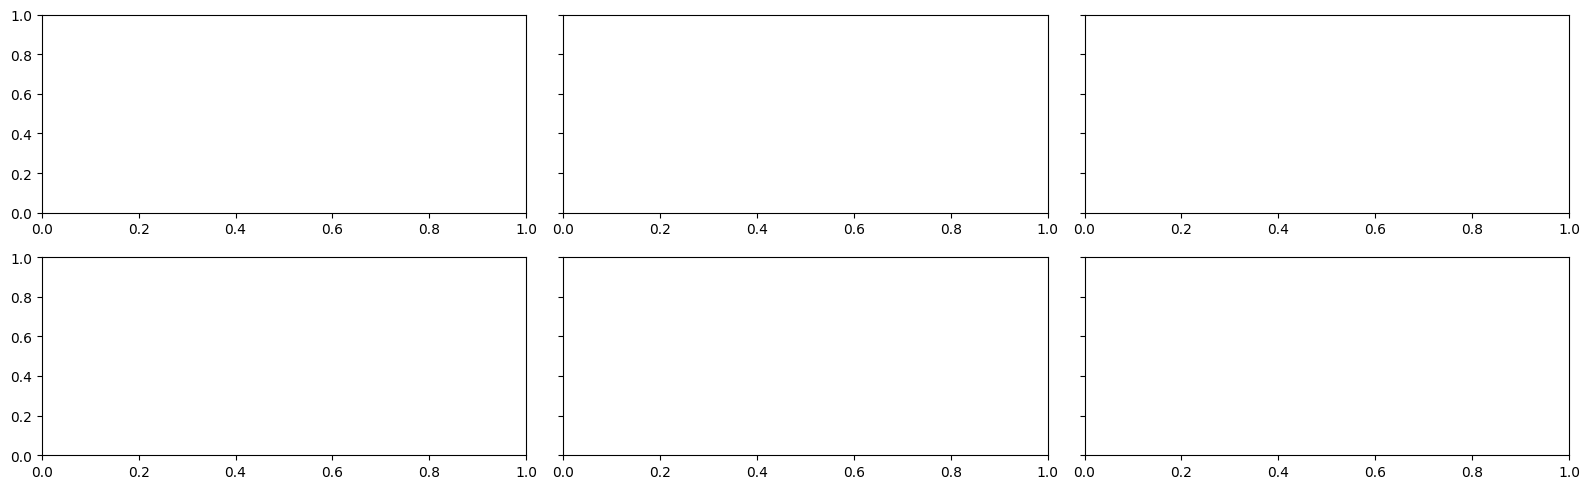

In [163]:
# The "Future" figure with twin axes and rotated x-labels
fig, axes = plt.subplots(2, 3, figsize=(16, 5), sharey=True)
axes_top = axes[0]  # Top row
axes_bot = axes[1]  # Bottom row

for i, (param,  in enumerate(zip(aggregated.keys, best_results.keys)):

    if i > axes.shape[0]:
        break
    
    keys = list(data[param].keys())
    min_rwps = [np.min(data[param]["agg"][k]["rwp"]) for k in keys]

    ax = axes_top[i]
    ax.plot(data[param]["best"]["pxrd_ref"]["iq"])

    ax = axes_bot[i]
    ax.plot(keys, min_rwps, label="Min Rwp", color="C0")

    ax.set_xlabel(param)
    
    if i == 0:
        ax.set_ylabel("Min Rwp", color="C0")

    # Rotate x-axis labels for readability
    ax.set_xticks(keys)
    ax.set_xticklabels(keys, rotation=90, ha="center")

fig.tight_layout()
plt.show()

In [ ]:
# plt.plot(params, rwps)
plt.plot(params, best_rwps)

In [36]:
def the_figure(result_path):
    # Load data
    with open(result_path, "rb") as f:
        data = pickle.load(f)
    results = data["results"]
    default_params_dict = data["config"]["default_params_dict"]
    params_dict = data["config"]["params_dict"]

    # The "Future" figure
    fig, axes = plt.subplots(2, 8, figsize=(16,5), sharey=True)

    axes_top = axes[0,:]
    axes_bot = axes[1,:]

    fig.tight_layout()
    plt.show()

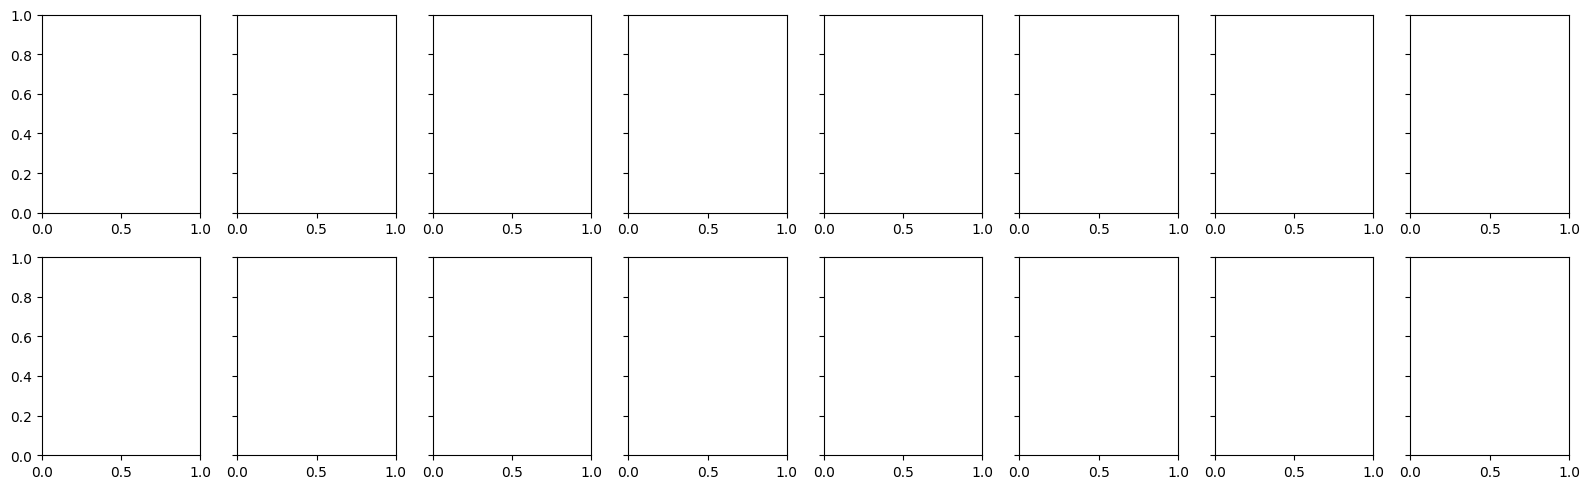

In [37]:
the_figure("../ablation_results_comp.pkl")

{'qmin': 0.0, 'qmax': 10.0, 'qstep': 0.01, 'base_fwhm': 0.05, 'eta': 0.5}
{'chebychev_order': 6}


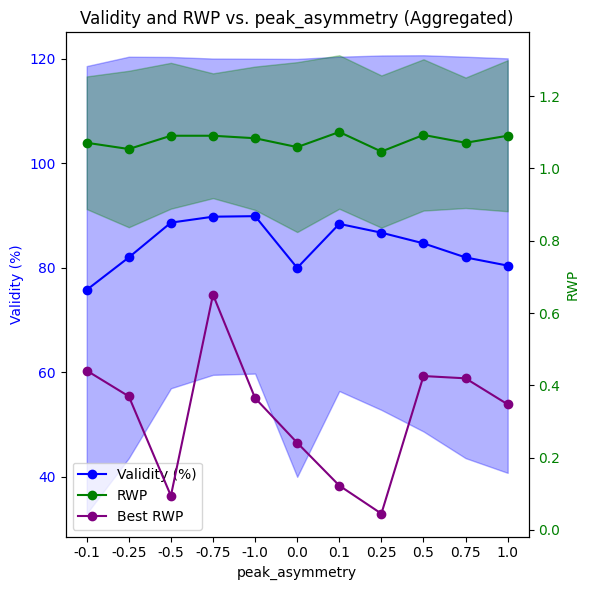

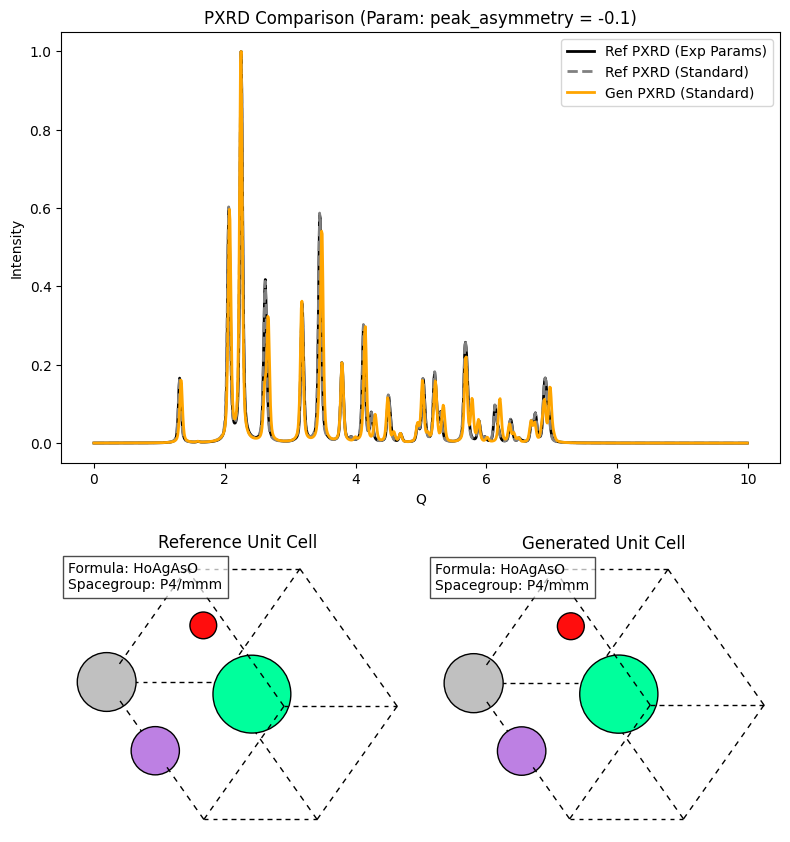

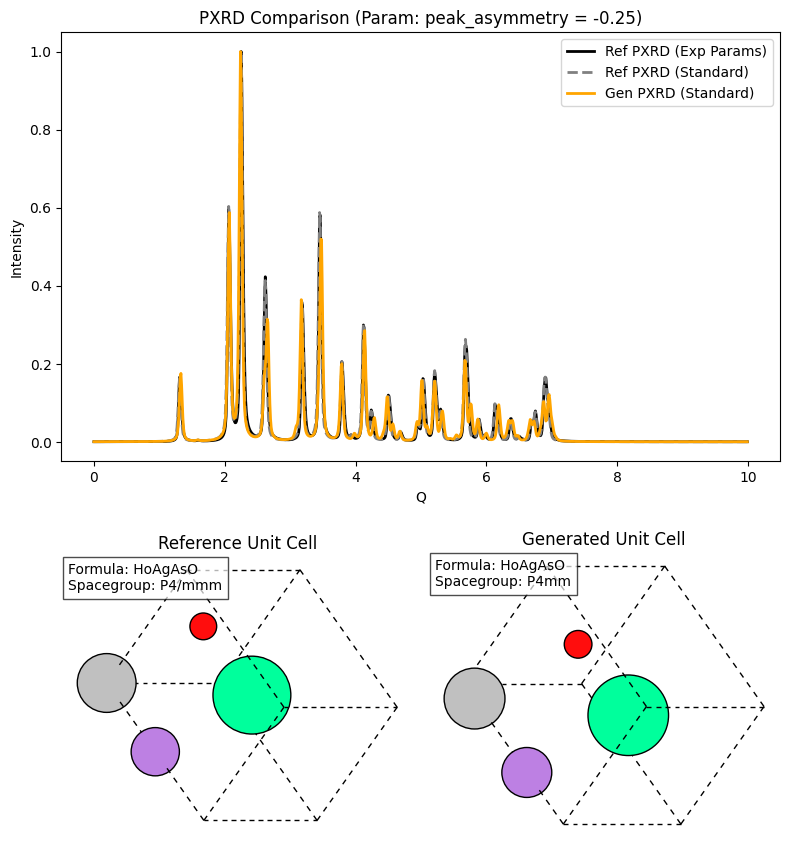

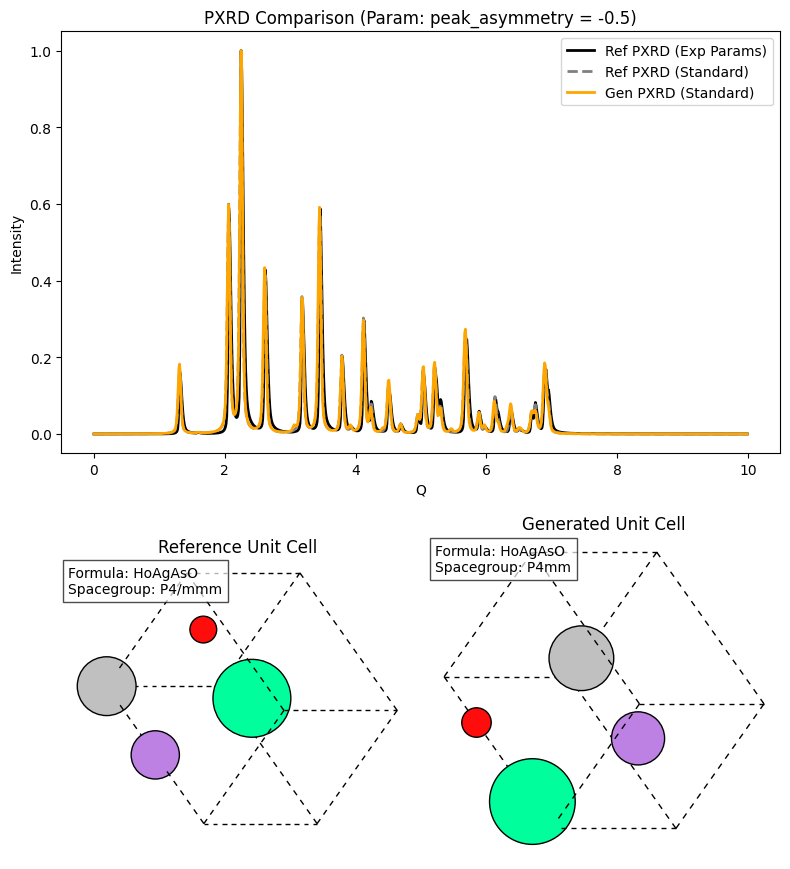

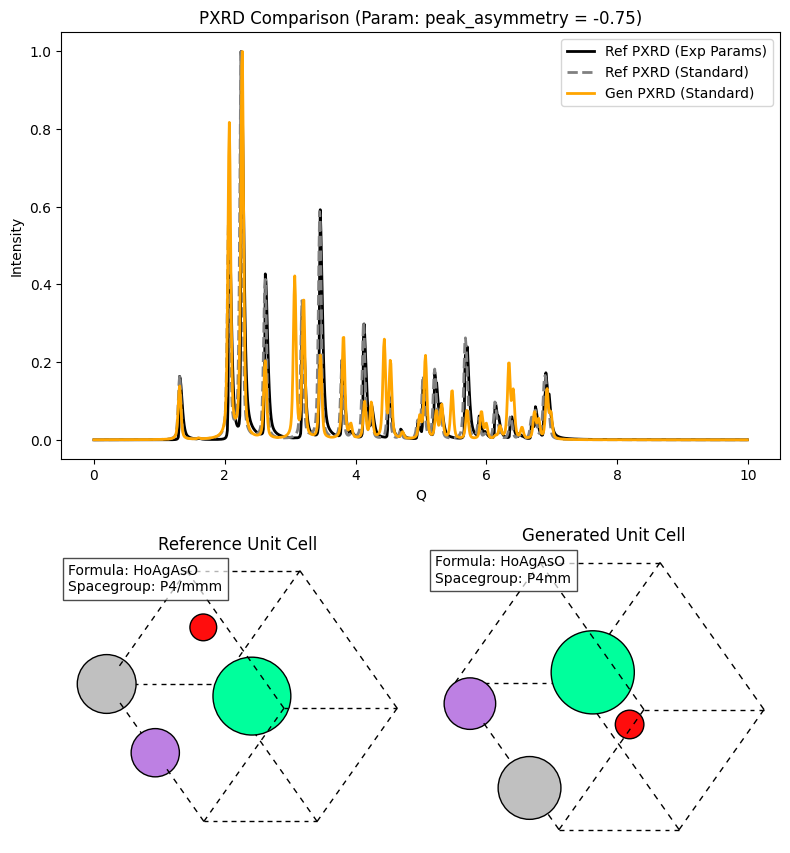

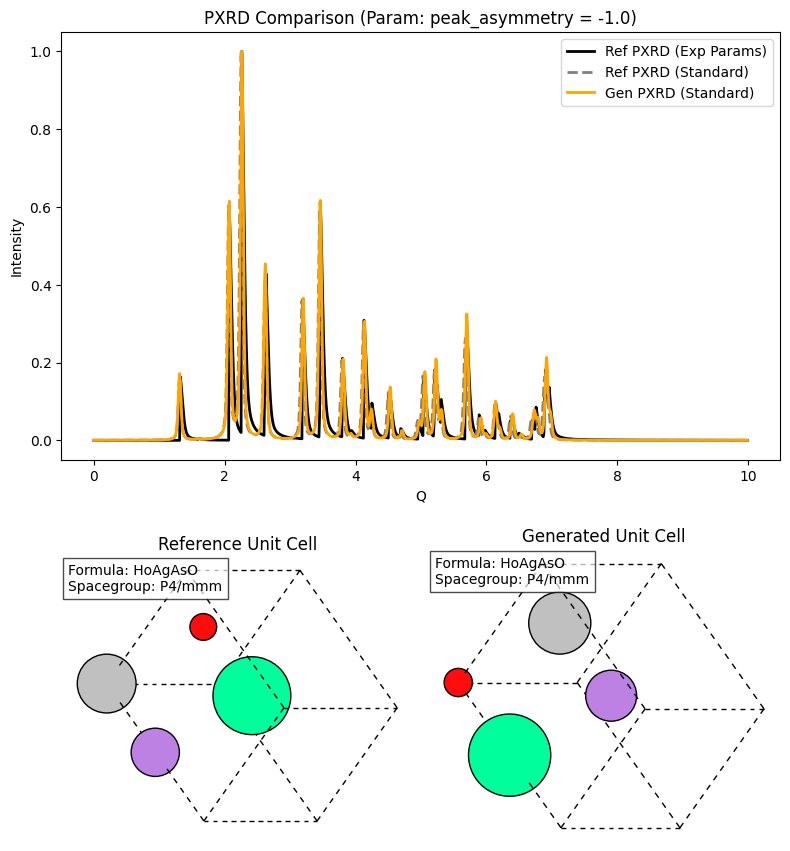

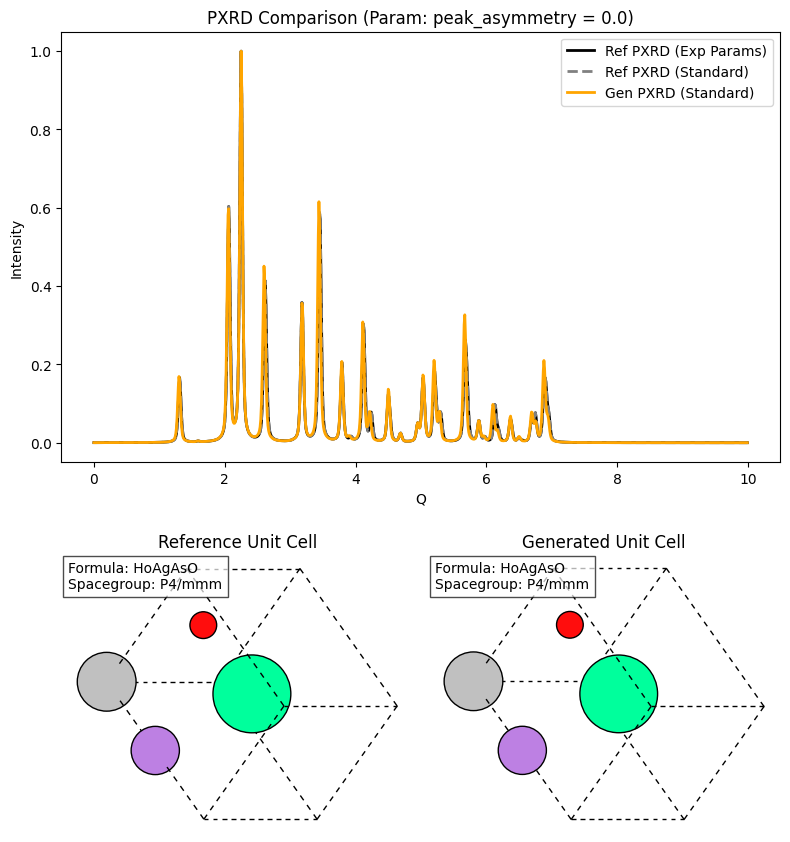

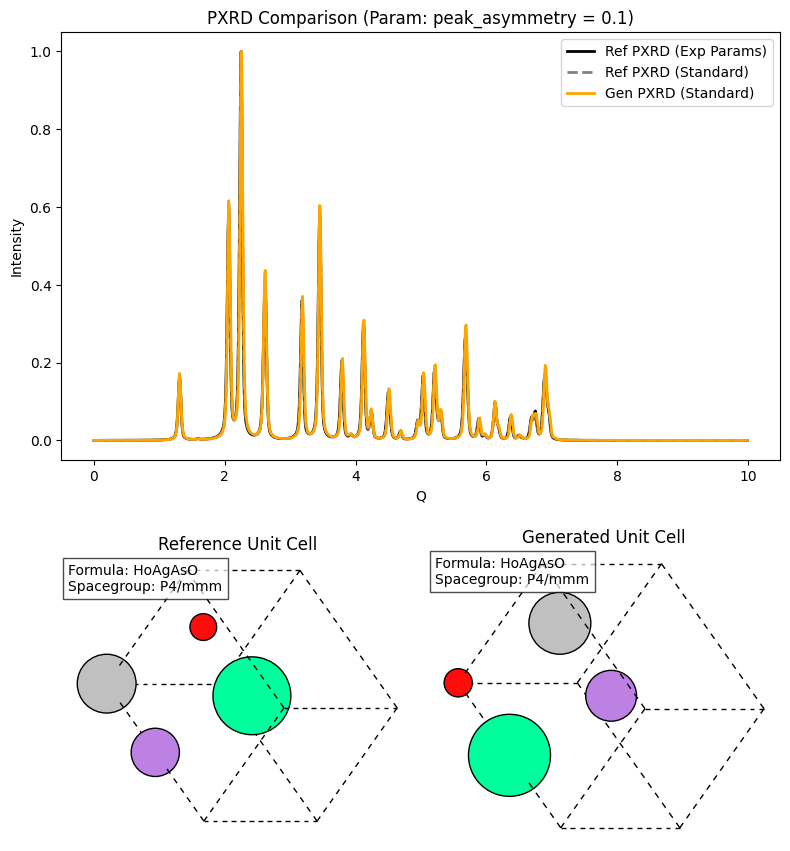

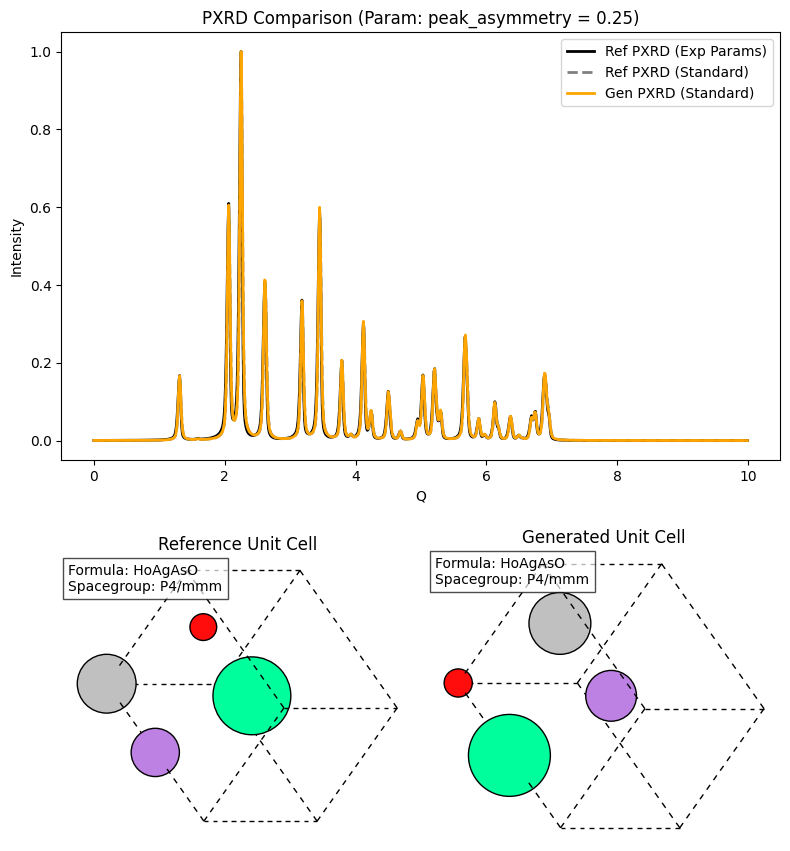

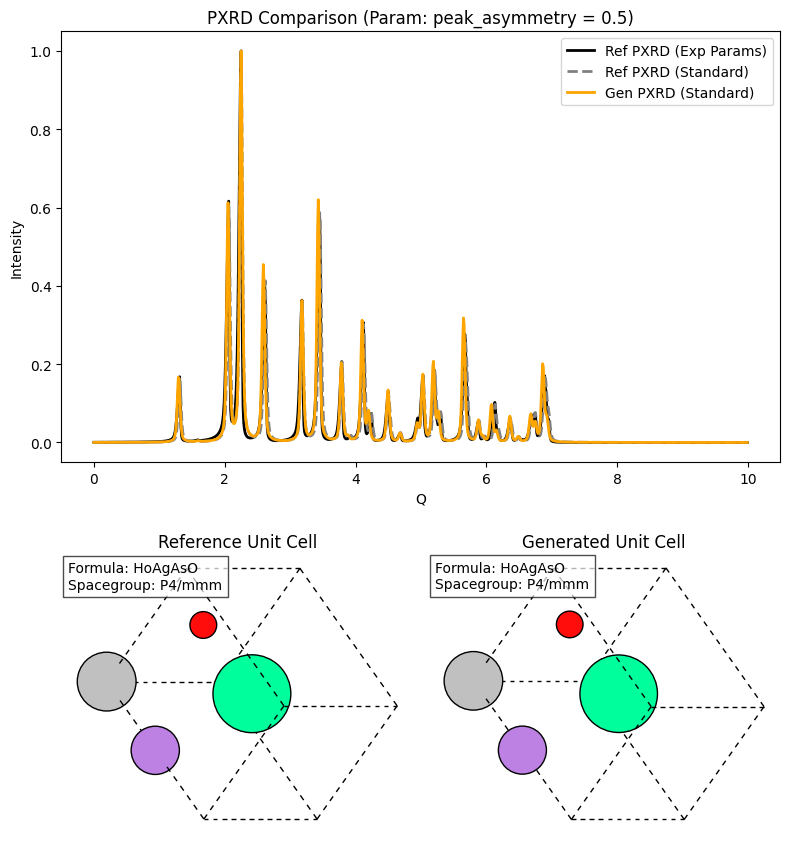

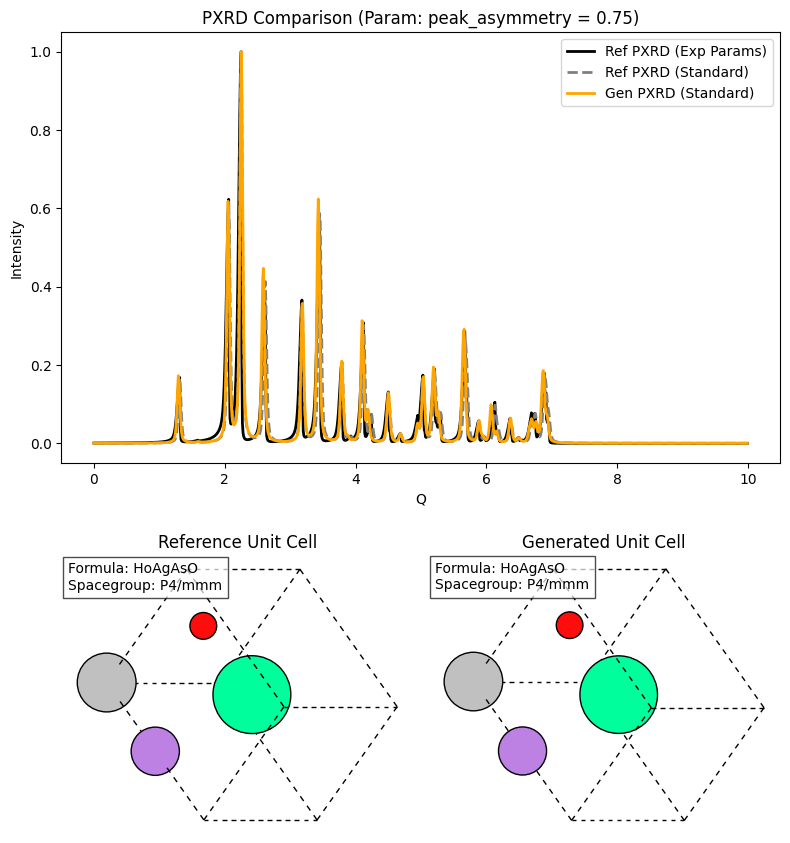

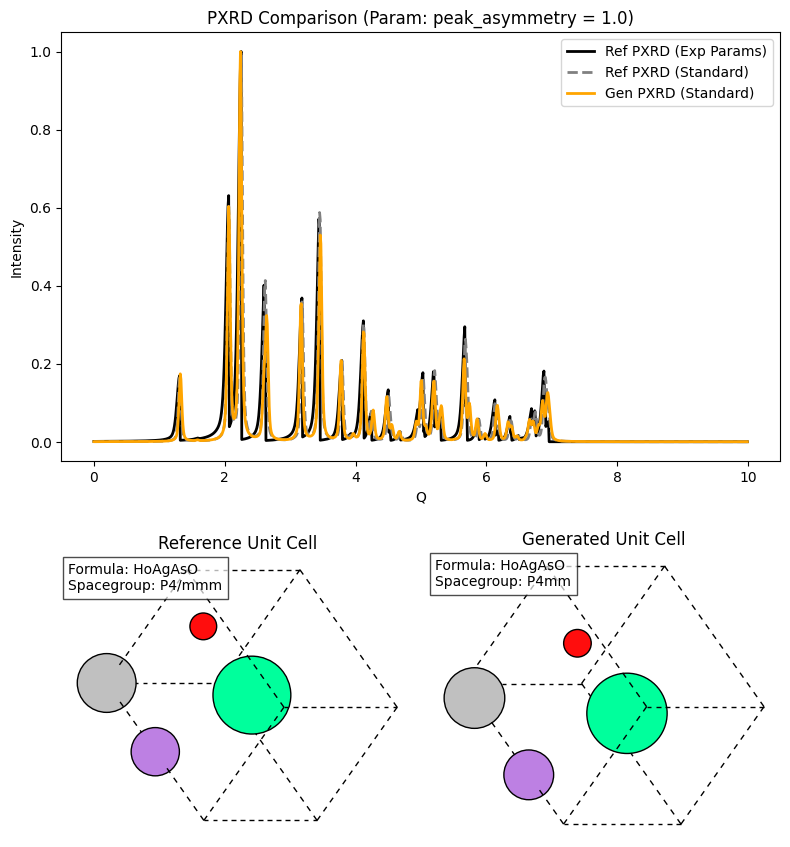

In [15]:
combined_analysis_and_visualization("../ablation_results_comp.pkl",
                                    "peak_asymmetry", prefix="comp", folder="ablation")

In [17]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

# Load data
with open('../testing_experimental_results_compSG.pkl', "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]

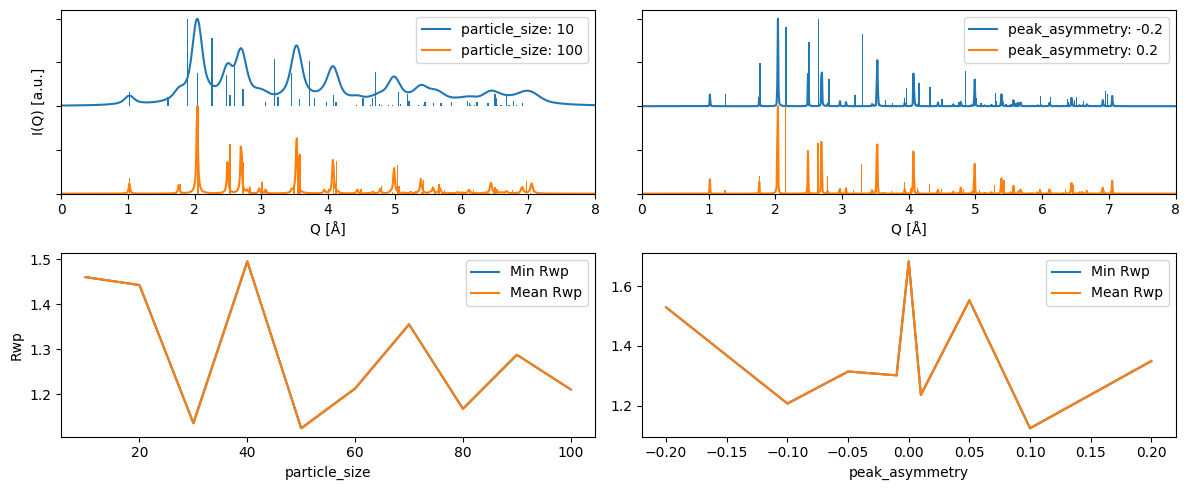

In [18]:
# The "Future" figure with twin axes and rotated x-labels
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

for i, (param_key, param_val) in enumerate(results.items()):
    if i > axes.shape[0]:
        break
    param_val_keys = list(param_val.keys())
    min_rwps = np.array([param_val[key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in param_val[key]["experiments"]]) for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in param_val[key]["experiments"]]) for key in param_val_keys])

    examples_indices = [0,-1]
    for j, ex in enumerate(examples_indices):
        k = param_val_keys[ex]
        q = param_val[k]["best_experiment"]["pxrd_ref"]["q"]
        iq = param_val[k]["best_experiment"]["pxrd_ref"]["iq"]
        p = axes[0,i].plot(q, iq-j, label=f"{param_key}: {k}")
        
        q = param_val[k]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq = param_val[k]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0] / 100
        
        axes[0,i].bar(x=q, height=iq, bottom=-j, width=0.02, color=p[0].get_color(), zorder=100)
    axes[0,i].legend()
    axes[0,0].set_ylabel('I(Q) [a.u.]')
    
    axes[0,i].set(
        yticklabels=[],
        xlim=(0.0, 8.0),
        xlabel='Q [Å]'
    )
    
    axes[1,i].plot(param_val_keys, min_rwps, label="Min Rwp", color="C0")
    axes[1,i].plot(param_val_keys, mean_rwps, label="Mean Rwp", color="C1")
    axes[1,i].fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps, color='C1', alpha=0.3)
    
    axes[1,i].legend()
    axes[1,i].set(
        xlabel=param_key,
    )
    axes[1,0].set_ylabel('Rwp')
    axes[1,i].legend()

fig.tight_layout()
plt.show()